# Design Single Country Nat Cat Bonds

In [29]:
#import general packages
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#import climada stuff
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.util.api_client import Client
from climada.engine import ImpactCalc

%load_ext autoreload
%autoreload 2
import haz_storm as hst
import exposures as ex
import grider as grd
import impact as cimp
import functions as fct
import pay_opt as popt

client = Client()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Perform natural hazard simulation 
### Define variables for cat bonds

In [2]:
#choose storm basin to load
#The STORM basins are: 'EP','NA','NI','SI','SP','WP'
basins = ['SI']

#choose country
country = 174

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
upper_rp = 200
lower_rp = 100

### Load TC Tracks for basin

currently not needed because I incorporated it into the ex.init_TC_exp function -> still coudnt figure out how to load exisitng tc track files -> it takes forever without throwing an error

In [ ]:
#storms_basin = hst.init_STORM_tracks(basins=basins, load_fls=False)

### Generate Exposure Data and TC hazards impacting selected exposure
1. Generate exposure data using newest available data. Can choose fin_mode myself, reference year, and resolution. <br>
2. Generate centroids at the locations of the exposed assets <br>
3. Filter tc tracks so that dataset only includes tracks which affect chosen exposure locations <br>
4. Generate tc hazards


STORM basin of country:  SI
----------------------Loading Exposure----------------------
----------------------Loading Hazard----------------------


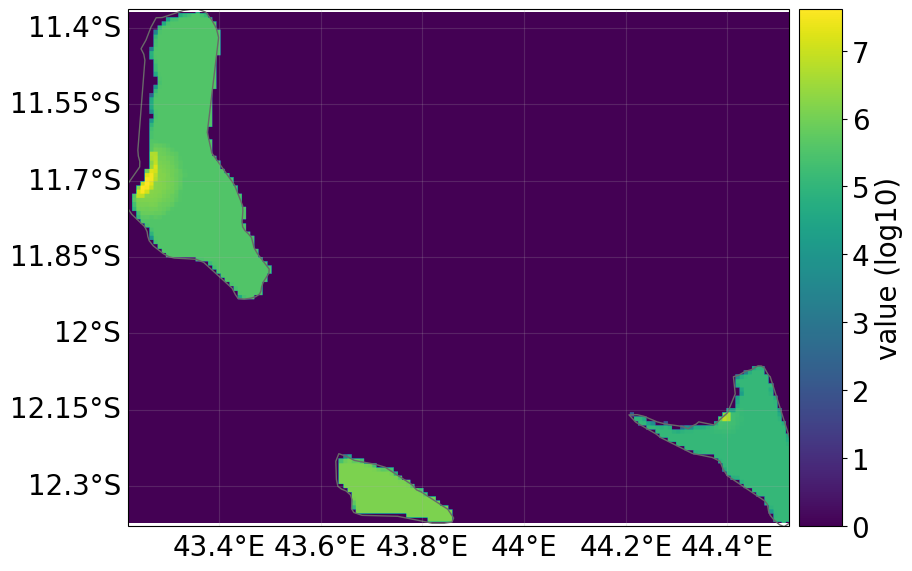

In [4]:
exp, applicable_basins, storm_basin_sub, tc_storms = ex.init_TC_exp(basins, country, load_fls=True)

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:93: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  


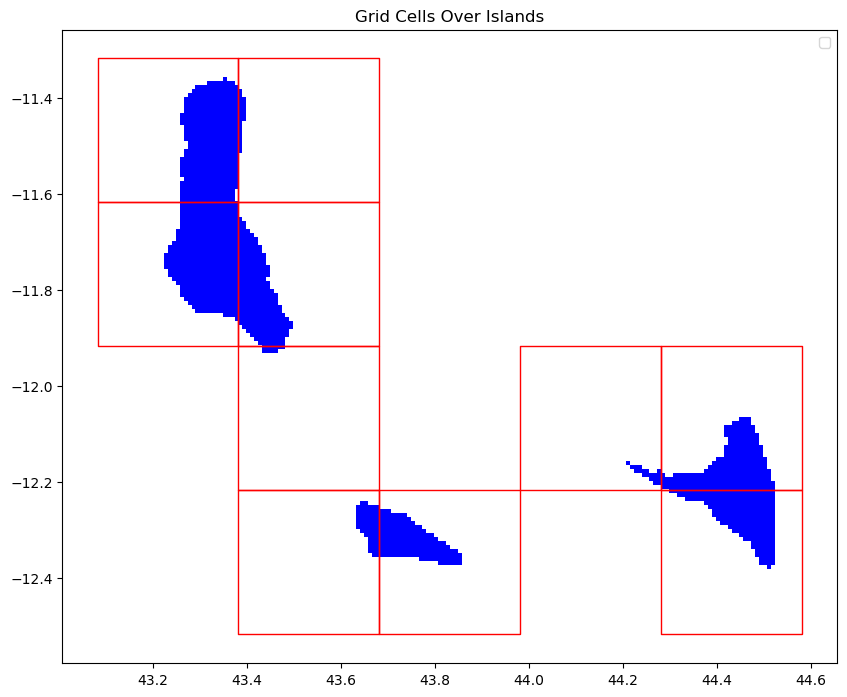

In [17]:
rst_grid = grd.init_grid(exp)

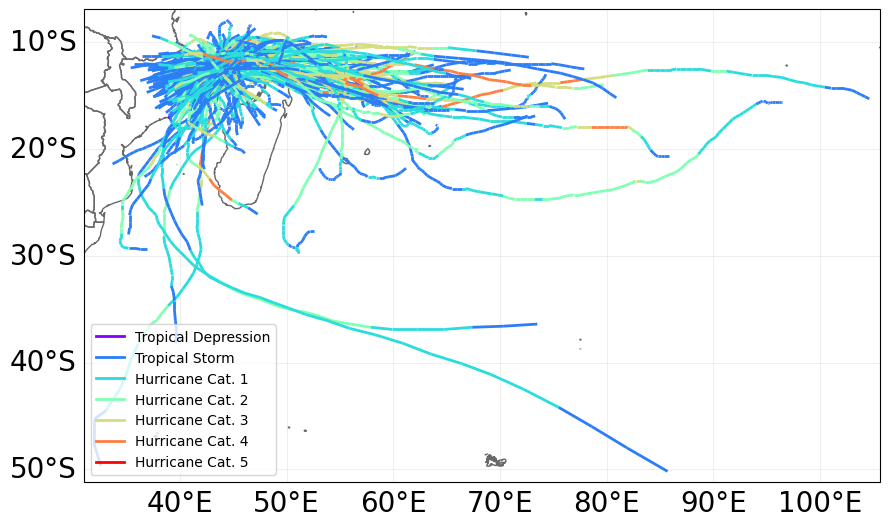

In [10]:
#plot filtered tc hazards
ax_sub = storm_basin_sub.plot()
ax_sub.get_legend()._loc = 3

### Calculate Impact
1. Calculate impact matrix
2. Determine exposure points per grid cell
3. Calculate total impacts per grid cell and event

In [18]:
print(rst_grid)

                                             geometry grid_letter
2   POLYGON ((43.38183 -11.91817, 43.38183 -11.618...           A
7   POLYGON ((43.68183 -11.91817, 43.68183 -11.618...           B
3   POLYGON ((43.38183 -11.61817, 43.38183 -11.318...           C
8   POLYGON ((43.68183 -11.61817, 43.68183 -11.318...           D
5   POLYGON ((43.68183 -12.51817, 43.68183 -12.218...           E
10  POLYGON ((43.98183 -12.51817, 43.98183 -12.218...           F
6   POLYGON ((43.68183 -12.21817, 43.68183 -11.918...           G
16  POLYGON ((44.28183 -12.21817, 44.28183 -11.918...           H
21  POLYGON ((44.58183 -12.21817, 44.58183 -11.918...           I
20  POLYGON ((44.58183 -12.51817, 44.58183 -12.218...           J


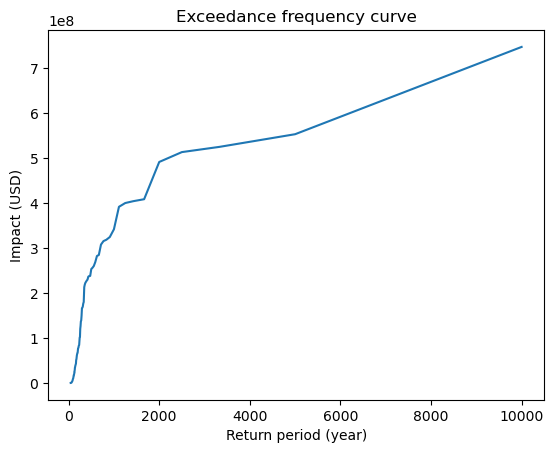

In [27]:
imp, imp_per_exp, agg_exp, imp_grid_evt = cimp.init_imp(exp, tc_storms, rst_grid) 

## Optimize insurance policies

### Calculate return periods for grid cells

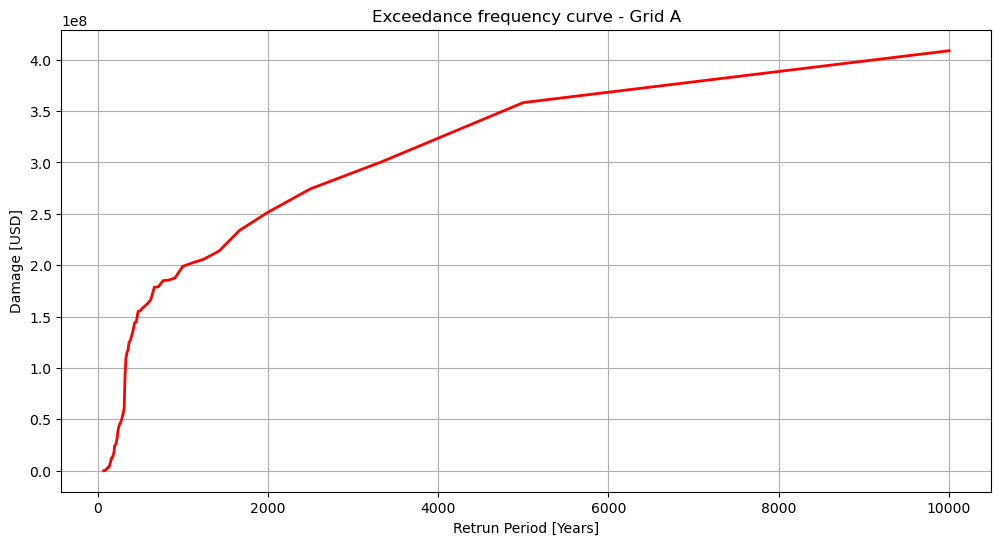

In [43]:
#Create an empty DataFrame
rp_dam_grid = pd.DataFrame(columns=['Grid','Upper','Lower'])

dam_per_grid = {} #empty dictionary where to save dataframes of damage per grid cell
#loop through damages per event
for i in imp_grid_evt:
    number = ord(i) - 65 #transform grid letter to number
    df = pd.DataFrame({'Damage': imp_grid_evt[i]}) #get damages per grid
    df['Rank'] = df['Damage'].rank(ascending=False, method='min') #rank damages
    df['RP'] = (r + 1)/df['Rank'] #calcualte return period per damage
    df = df.sort_values(by='RP') 
    dam_per_grid[i] = df #save damages per grid cell in dictionary
    rp_dam_grid.loc[number] = [i, fct.calc_rp(df,upper_rp), fct.calc_rp(df,lower_rp)] #calculate damage of certain return periods

#Create a plot
plt.figure(figsize=(12, 6))

#Plot a line connecting the points
plt.plot(dam_per_grid['A']['RP'], dam_per_grid['A']['Damage'], color='red', linestyle='-', linewidth=2)

#Add labels and title
plt.xlabel('Retrun Period [Years]')
plt.ylabel('Damage [USD]')
plt.title('Exceedance frequency curve - Grid A')

# Show the plot
plt.grid(True)
plt.show()

### Create data frame containing maximum wind speeds per grid and event

We can also try mean, median, etc....

In [48]:
ws_grid = {letter: [None] * len(tc_storms.event_id) for letter in agg_exp.keys()}

for i in range(len(tc_storms.event_id)):
    for letter, line_numbers in agg_exp.items():
        selected_values = tc_storms.intensity[i, line_numbers]
        ws_grid[letter][i] = selected_values.max()

ws_grid = pd.DataFrame.from_dict(ws_grid)

### Create filtered damage data frame using minimum and maximum bounds to damage
To be used for calibration

when it goes to pooling the available nominal increases so also the upper payout limit increases

Report coverage for unfiltered damages. 

Go the other way around and say cover damages with max x% of e.g. GDP

Allow max payout to be equal to nominal for also only one grid cell.

In [49]:
imp_grid_evt_flt = imp_grid_evt.copy()

#the current implimitation sets damages below the lower return period to zero but does not affect damages higher than upper return period
for i in range(len(rp_dam_grid)):
    max_val = rp_dam_grid.loc[i,'Upper']
    min_val = rp_dam_grid.loc[i,'Lower']
    for j in range(len(imp_grid_evt)):
        sel_val = imp_grid_evt.iloc[j,i]
        if sel_val > max_val:
            imp_grid_evt_flt.iloc[j,i] = sel_val
        elif sel_val < min_val:
            imp_grid_evt_flt.iloc[j,i] = 0
        else:
            pass

In [50]:
#define nominal
nominal = imp.calc_freq_curve(200).impact
print(nominal)

68281241.57656431


### Define objective function

In [51]:
def slope(x, y, min_pay, max_pay):
    m = (max_pay - min_pay) / (y - x)
    return m

def intercept(nominal, m, y):
    b = nominal - (m * y)
    return b

def calculate_payout(x, y, haz_int, max_min_pay, grid):
    payout_df = pd.DataFrame(index=np.arange(len(haz_int)), columns=np.arange(1))
    for i in range(len(haz_int)):
        filtered_rows = pd.DataFrame(max_min_pay.iloc[grid]) # Filter rows where 'Grid' has the value 'grid'
        #max_pay = filtered_rows.loc['Upper'].iloc[0]
        max_pay = nominal
        min_pay = filtered_rows.loc['Lower'].iloc[0]
        m = slope(x, y, min_pay, max_pay)
        b = intercept(max_pay, m, y)
        wind_speed = haz_int.iloc[i, grid]

        if x <= wind_speed <= y:
            payout = m * wind_speed + b
        elif wind_speed > y:
            payout = max_pay
        else:
            payout = 0

        payout_df.iloc[i,0] = payout

    return payout_df

def objective_function(params, damage_matrix):
    """Objective function to minimize.
    
    Parameters
    ----------
    params : list
        List of parameters [x, y] for each grid cell.
    damage_matrix : np.ndarray
        Matrix of damage values.
        
    Returns
    -------
    float
        Sum of squared differences between calculated payout and damage.
    """
    num_cells = damage_matrix.shape[1]  # Number of grid cells
    total_diff = 0

    # Extract parameters for each grid cell
    for cell_idx in range(num_cells):
        x = params[cell_idx * 2]      # x for this grid cell
        y = params[cell_idx * 2 + 1]  # y for this grid cell
        
        # Compute payouts
        payouts = calculate_payout(x, y, ws_grid, rp_dam_grid, cell_idx)
        
        # Compute the squared difference
        diff = np.sum(((payouts.iloc[:, 0] - damage_matrix.iloc[:, cell_idx]) ** 2)** 0.5)
        total_diff += diff

    return total_diff

### Perform optimization

In [52]:
from scipy.optimize import minimize

#Initial guess for parameters
sequence = [30, 40]
length = 20
initial_params = np.tile(sequence, length // len(sequence))

#Define bounds for minimum and maximum wind speeds
bounds = [(25, 39) if i % 2 == 0 else (40, 200) for i in range(len(initial_params))]


#Perform optimization
result = minimize(
    fun=objective_function,
    x0=initial_params,
    args=(imp_grid_evt_flt,), 
    method='L-BFGS-B',  #How to choose optimization method?
    bounds=bounds  
)

#Extract the optimized parameters
optimized_params = result.x
print("Optimized parameters:", optimized_params)

print('Missmatch between payment and damage:',result.fun)

# Reshape parameters into a more interpretable form if needed
optimized_xs = optimized_params[0::2]  #minimum threshold of windspeeds
optimized_ys = optimized_params[1::2]  #maximum threshold of windspeeds


Optimized parameters: [ 32.0570236   43.01077739  35.204113    67.91809092  34.47003821
  57.12548882  39.         200.          34.96206751  76.48294602
  34.42932071  50.37105268  39.         200.          39.
 200.          34.71402888 105.64339217  36.48764951 125.49352213]
Missmatch between payment and damage: 5595254487.016019


### Create payout vs damage matrix per event
Plot it on 1:1 scale

In [77]:
payout_evt_grd = {letter: [None] * len(tc_storms.event_id) for letter in agg_exp.keys()}
payout_evt_grd = pd.DataFrame(payout_evt_grd)
pay_dam_df = pd.DataFrame({'pay': [0] * len(tc_storms.event_id), 'damage': [0] * len(tc_storms.event_id)})

for i in range(len(imp_grid_evt_flt)):
    tot_dam = np.sum(imp_grid_evt_flt.iloc[i, :])
    pay_dam_df.loc[i,"damage"] = tot_dam
    for j in range(len(ws_grid.columns)):
        tot_payout = calculate_payout(optimized_xs[j], optimized_ys[j], ws_grid, rp_dam_grid, j)
        payout_evt_grd.iloc[:,j] = tot_payout.iloc[:,0]
    tot_pay = np.sum(payout_evt_grd.iloc[i, :])
    if tot_pay > nominal:
            tot_pay = nominal
    else: 
        pass
    pay_dam_df.loc[i,"pay"] = tot_pay

C:\Users\kaibe\AppData\Local\Temp\ipykernel_18604\2570711157.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '408293461.3343402' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pay_dam_df.loc[i,"damage"] = tot_dam
C:\Users\kaibe\AppData\Local\Temp\ipykernel_18604\2570711157.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '68281241.57656431' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pay_dam_df.loc[i,"pay"] = tot_pay


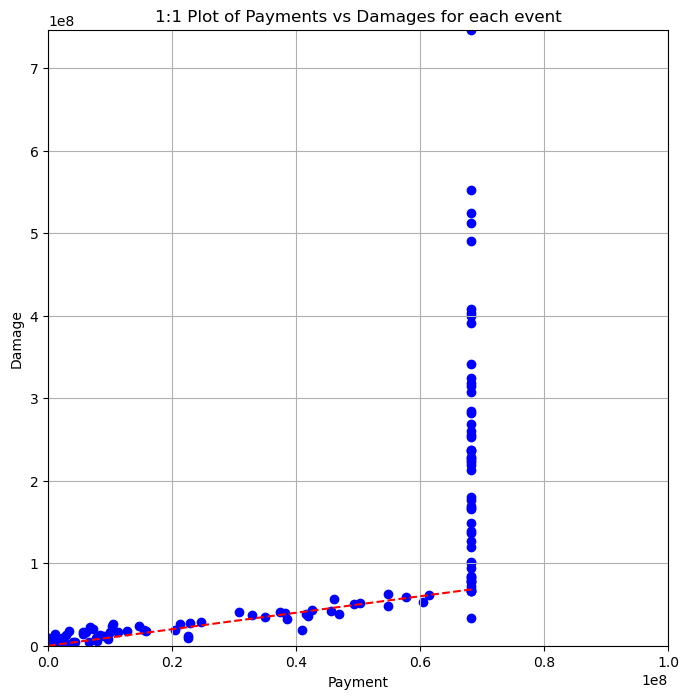

In [82]:
# Create a 1:1 plot (scatter plot with equal scales)
plt.figure(figsize=(8, 8))  # Set the figure size
plt.scatter(pay_dam_df['pay'], pay_dam_df['damage'], color='blue', marker='o')

# Setting equal scaling for x and y axes
plt.xlim(pay_dam_df['pay'].min(), 1e8)
plt.ylim(pay_dam_df['damage'].min(), pay_dam_df['damage'].max())

# Add a 1:1 line for reference
plt.plot([pay_dam_df['pay'].min(), pay_dam_df['pay'].max()], [pay_dam_df['pay'].min(), pay_dam_df['pay'].max()], color='red', linestyle='--')

# Set axis labels
plt.xlabel('Payment')
plt.ylabel('Damage')

# Set aspect ratio to 1 to make the plot square
#plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.title('1:1 Plot of Payments vs Damages for each event')
plt.grid(True)
plt.show()

### Set up premium calculation function

R² = 0.640603377049146


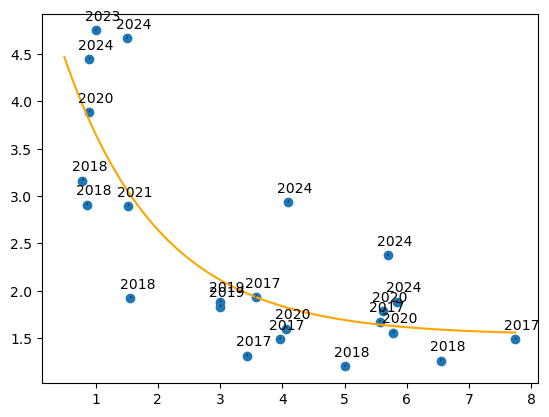

In [45]:
from scipy.optimize import curve_fit

ibrd_bonds = pd.read_excel(r"C:\Users\kaibe\Documents\ETH_Zurich\Thesis\Data\IBRD_bonds.xlsx")

def monoExp(x, a, k, b):
    return a * np.exp(-k * x) + b

# perform the fit
#p0 = (4.5, .1, 50) # start with values near those we expect
params, cv = curve_fit(monoExp, ibrd_bonds['Expected Loss'], ibrd_bonds['Risk Multiple'])

a, k, b = params

x_fit = np.linspace(0.5, ibrd_bonds['Expected Loss'].max(), 100)
y_fitted = monoExp(x_fit, a, k, b)

squaredDiffs = np.square(ibrd_bonds['Risk Multiple'] - monoExp(ibrd_bonds['Expected Loss'], a, k, b))
squaredDiffsFromMean = np.square(ibrd_bonds['Risk Multiple'] - np.mean(ibrd_bonds['Risk Multiple']))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")


plt.scatter(ibrd_bonds['Expected Loss'], ibrd_bonds['Risk Multiple'])
# Annotate each point with its label
for i in range(len(ibrd_bonds['Risk Multiple'])):
    plt.annotate(
        ibrd_bonds['Date'][i],  # Text to display
        (ibrd_bonds['Expected Loss'][i], ibrd_bonds['Risk Multiple'][i]),  # Point location
        xytext=(5, 5),  # Offset position (adjust as needed)
        textcoords='offset points',  # Use offset in points
        arrowprops=dict(arrowstyle='-', color='black', lw=0.5),  # Arrow style
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )
plt.plot(x_fit, y_fitted, color = 'orange', label="fitted")
plt.show()

### Calculate cat bond metrics
1. Determine needed nominal
2. Perform Monte-Carlo Simulation
3. Calculate Metrics
    - Expected Loss
    - Attachment Probability
    - Value at risk
    - Coverage
    - Basis-Risk
    - Expected Shortfall

In [55]:
#needed nominal so that the probabilty of exceeding the nominal is 1/1000
#nominal = fct.calc_rp(pay_dam_df, 3000, damage=False)
#print('Nominal: ', nominal)

#total exposure
tot_exp = exp.gdf['value'].sum()

#percentage of nominal relative to total exposure
max_rel_imp = nominal/tot_exp
print('Covered exposure relative to GDP: ', max_rel_imp)

Covered exposure relative to GDP:  0.05573800558011975


In [70]:
#transform payouts to numpy array
payouts = pay_dam_df['pay'].to_numpy()
damages = pay_dam_df['damage'].to_numpy()

# Parameters for the Monte Carlo Simulation
num_simulations = 10000  # Number of Monte Carlo iterations
simulated_losses = []
simulated_damages = []
event_probability = len(payouts) / r

#Monte Carlo Simulation
for _ in range(num_simulations):
    # randomly generate number of events in one year using poisson distribution and calculated yearly event probability
    num_events = np.random.poisson(lam=event_probability)
    # If there are events in the year, sample that many payouts and the associated damages
    if num_events > 0:
        random_indices = np.random.randint(0, len(payouts), size=num_events)
        simulated_payouts = payouts[random_indices]
        selected_damages = damages[random_indices]
        total_damage = np.sum(selected_damages)
        total_loss = np.sum(simulated_payouts)
        if total_loss > nominal:
            total_loss = nominal
        else: 
            pass
    else:
        total_loss = 0
        total_damage = 0  # No events, no loss damage

    simulated_losses.append(total_loss)
    simulated_damages.append(total_damage)

# Convert simulated losses to a DataFrame
simulated_losses = pd.Series(simulated_losses)
simulated_damages = pd.Series(simulated_damages)

In [83]:
#Expected Loss
exp_loss_hist = pay_dam_df['pay'].sum() / r
exp_loss_sim = simulated_losses.mean()

rel_exp_loss_hist = exp_loss_hist / nominal
rel_exp_loss_sim = exp_loss_sim / nominal

print(f"Expected Loss (historic): {exp_loss_hist}")
print(f"Expected Loss (simulation): {exp_loss_sim}")

print(f"Relative Expected Loss (historic): {rel_exp_loss_hist}")
print(f"Relative Expected Loss (simulation): {rel_exp_loss_sim}")

#Attachment Probability
att_prob_hist = (pay_dam_df['pay'] > 0).sum() / r
att_prob_sim = (simulated_losses > 0).sum() / num_simulations

print(f"Attachment Probability (historic): {att_prob_hist}")
print(f"Attachment Probability (simulation): {att_prob_sim}")

#Coverage
cov_hist = pay_dam_df['pay'].sum() / pay_dam_df['damage'].sum()
cov_sim = sum(simulated_losses) / sum(simulated_damages)

print(f"Coverage (historic): {cov_hist}")
print(f"Coverage (simulation): {cov_sim}")

#Basis Risk
ba_ri_hist = (pay_dam_df['damage'].sum() - pay_dam_df['pay'].sum()) / len(payouts)
ba_ri_sim = (sum(simulated_damages) - sum(simulated_losses)) /len(payouts)

print(f"Basis-Risk (historic): {ba_ri_hist}")
print(f"Basis-Risk (simulation): {ba_ri_sim}")

#Value at Risk
VaR_95 = simulated_losses.quantile(0.95)
VaR_99 = simulated_losses.quantile(0.99)

print(f"Value at Risk (95% confidence): {VaR_95}")
print(f"Value at Risk (99% confidence): {VaR_99}")

#Expected shortfall
ES_95 = simulated_losses[simulated_losses > VaR_95].mean()
ES_99 = simulated_losses[simulated_losses > VaR_99].mean()

print(f"Expected Shortfall (95% confidence): {ES_95}")
print(f"Relative Expected Shortfall (95% confidence): {ES_95 / nominal}")


Expected Loss (historic): 493692.4315192686
Expected Loss (simulation): 466788.61154770106
Relative Expected Loss (historic): 0.007230279065234736
Relative Expected Loss (simulation): 0.006836264261895226
Attachment Probability (historic): 0.0111
Attachment Probability (simulation): 0.0107
Coverage (historic): 0.35556928598123644
Coverage (simulation): 0.37193332283528485
Basis-Risk (historic): 40856799.74231941
Basis-Risk (simulation): 35992896.60936484
Value at Risk (95% confidence): 0.0
Value at Risk (99% confidence): 3366290.2648591995
Expected Shortfall (95% confidence): 43625103.88296272
Relative Expected Shortfall (95% confidence): 0.6389032020462828


### Simulate a 3-year cat bond

In [136]:
#calculate premium
risk_multi = monoExp((rel_exp_loss_sim * 100), a, k, b)
p = rel_exp_loss_sim * risk_multi
print('The calculated risk spread is: ',p)
#risk free rate
rf_interest_rates = np.arange(0.001, 0.07, 0.01)

# Parameters for the Monte Carlo Simulation
term = 3 #time until maturation of bond
tot_simulated_ncf = []

premiums = np.arange(0.01, 0.15, 0.001)
sharpe_ratios_rf = {}

for rf in np.nditer(rf_interest_rates):
    rf_str = str(rf)
    sharpe_ratios = []
    for premium in np.nditer(premiums):
        #Monte Carlo Simulation
        tot_simulated_ncf = []
        for _ in range(num_simulations):
            simulated_ncf = []
            cur_nominal = nominal
            payout_happened = False
            for i in range(term):
                net_cash_flow = 0
                #randomly generate number of events in one year using poisson distribution and calculated yearly event probability
                num_events = np.random.poisson(lam=event_probability)
                #If there are events in the year, sample that many payouts and the associated damages
                if num_events == 0 and not payout_happened or cur_nominal == 0:
                    net_cash_flow = cur_nominal * (premium + rf)
                elif num_events > 0:
                    random_indices = np.random.randint(0, len(payouts), size=num_events)
                    simulated_payouts = payouts[random_indices]
                    sum_simulated_payouts = np.sum(simulated_payouts)
                    if sum_simulated_payouts == 0 and not payout_happened:
                        net_cash_flow = cur_nominal * (premium + rf)
                    elif sum_simulated_payouts > 0:
                        net_cash_flow = 0 - sum_simulated_payouts
                        cur_nominal += net_cash_flow
                        payout_happened = True
                        if cur_nominal < 0:
                            net_cash_flow = (cur_nominal - net_cash_flow) * -1
                            cur_nominal = 0
                        else:
                            pass

                simulated_ncf.append(net_cash_flow)
            tot_ncf = sum(simulated_ncf)
            tot_simulated_ncf.append(tot_ncf)

        # Convert simulated net cash flows to a series
        tot_simulated_ncf = pd.Series(tot_simulated_ncf)

        rel_simulated_ncf = tot_simulated_ncf / nominal
        
        std_ncf = rel_simulated_ncf.std(0, ddof=0)
        exp_ret = rel_simulated_ncf.mean()
        sharpe_ratio = (exp_ret - rf) / std_ncf
        sharpe_ratios.append(sharpe_ratio)
    sharpe_ratios_rf[rf_str] = sharpe_ratios



The calculated risk spread is:  0.02829753598090758


C:\Users\kaibe\AppData\Local\Temp\ipykernel_18604\4152507217.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  sp = np.mean(rel_simulated_ncf - rf) / np.std(rel_simulated_ncf)


KeyboardInterrupt: 

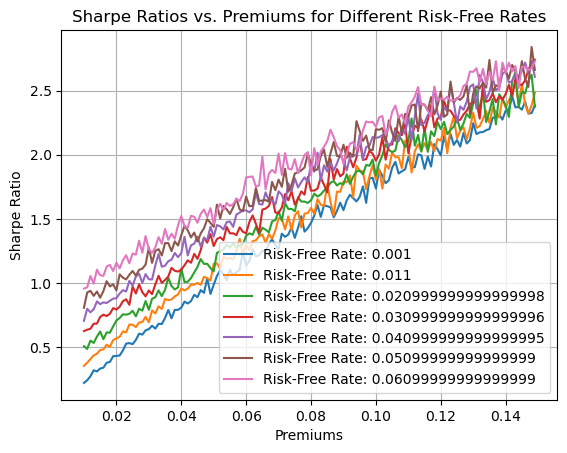

In [134]:
for rf in np.nditer(rf_interest_rates):
    rf_str = str(rf)  
    if rf_str in sharpe_ratios_rf:
        plt.plot(premiums, sharpe_ratios_rf[rf_str], label=f'Risk-Free Rate: {rf_str}')

plt.xlabel('Premiums')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios vs. Premiums for Different Risk-Free Rates')
plt.legend()
plt.grid(True)
plt.show()

In [132]:
print(premium)
print(rf)
print(nominal * (premium + rf) * 3)

print(rel_simulated_ncf.std(0, ddof=0))
print(std_ncf)

0.14899999999999988
0.06099999999999999
43017182.193235494
0.21928624795187882
0.21928624795187882
